In [1]:
'''
The Leung-Malik (LM) Filter Bank, implementation in python

T. Leung and J. Malik. Representing and recognizing the visual appearance of
materials using three-dimensional textons. International Journal of Computer
Vision, 43(1):29-44, June 2001.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
'''

import numpy as np
import matplotlib.pyplot as plt
import scipy

from skimage.util import montage
from PIL import Image
import math

In [2]:
'''
Function to compute gaussian derivatives of order 0 <= ord < 3
evaluated at x.
'''
def gaussian1d(sigma, mean, x, ord):
    x = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp(-(x*x)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x)/(var))
        return g
    else:
        g = g1*(((x*x) - var)/(var**2))
        return g


In [3]:
'''
Function to compute 2D gaussian.
'''
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

In [4]:
'''
Function to compute laplacian of gaussian.
'''
def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

In [5]:
def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)
    image = np.reshape(gx*gy,(sup,sup))
    return image

In [6]:
def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12


    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count  = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]  = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F

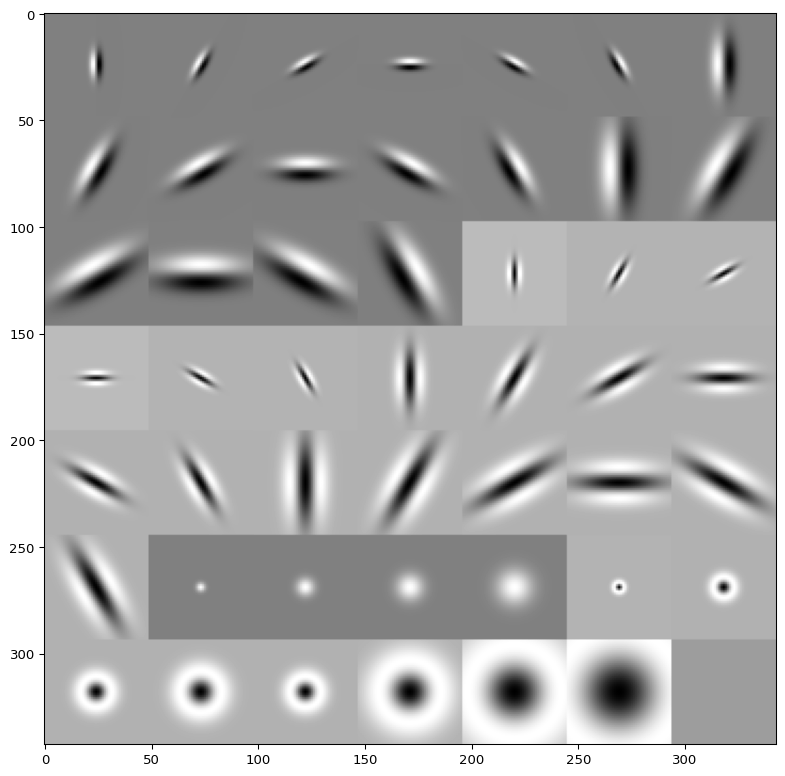

In [7]:
F = makeLMfilters()
plt.figure(figsize=(10,10), dpi=95)
plt.imshow(montage(F.transpose(2,1,0), rescale_intensity=True) , cmap='gray');

## Low-rank approximations
---

In [8]:
# SVD on single filter; seperable filter!
imy,imx,n = np.shape(F)
print(np.shape(F))

# Compute "narrow" SVD with min(m,n) singular values
X = F[:,:,0];
print(np.shape(X))
[U, s, Vh] = np.linalg.svd(X, full_matrices=False)
fy = U[:,0]*np.sqrt(s[0])
fx = np.sqrt(s[0])*Vh[0,:]
print(np.shape(fy))
print(np.shape(fx))

(49, 49, 48)
(49, 49)
(49,)
(49,)


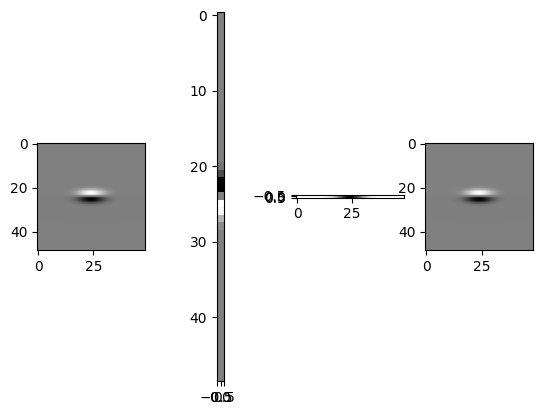

In [9]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(X,cmap='gray')
plt.subplot(1,4,2)
plt.imshow(fy.reshape(imy,1),cmap='gray')
plt.subplot(1,4,3)
plt.imshow(fx.reshape(1,imx),cmap='gray')
plt.subplot(1,4,4)
plt.imshow(fy.reshape(imy,1)@fx.reshape(1,imx),cmap='gray')

In [10]:
# SVD on filter bank
[U, s, Vh] = np.linalg.svd(F.reshape(imy*imx,n), full_matrices=False)

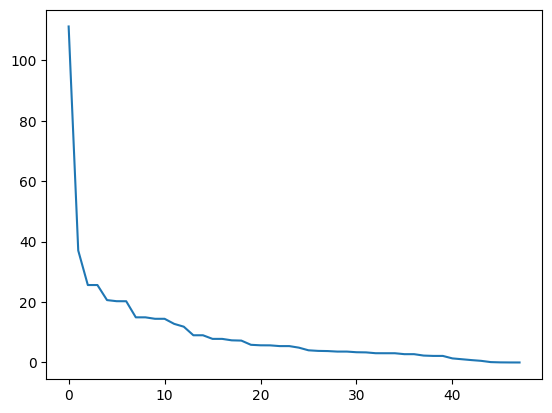

In [11]:
# Plot singular values
plt.figure()
plt.plot(s)

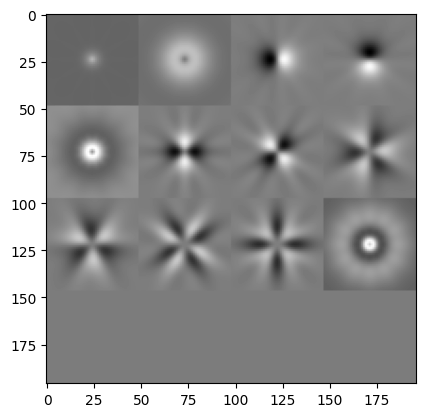

In [12]:
# Plot first K=9 eigenvectors
K  = 12
plt.figure()
plt.imshow( montage(U[:,:K].reshape(imy,imx,K).transpose(2,1,0)) , cmap='gray');

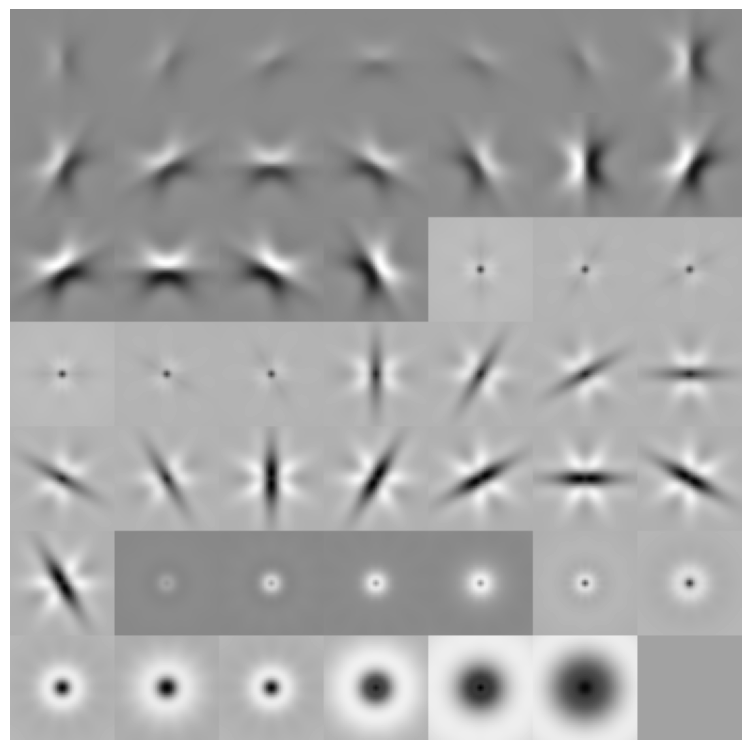

In [13]:
# Show best rank-K approximation of filter bank
Xr = U[:,:K] @ np.diag(s[:K]) @ Vh[:K,:]
plt.figure(figsize=(10,10), dpi=95)
plt.imshow(montage(Xr.reshape(imy,imx,n).transpose(2,1,0)) , cmap='gray')
plt.axis('off');
# fig.savefig('filter_reconstruct.jpg', bbox_inches='tight')